Epoch 0, Loss: 2.203264921263326e-05
Epoch 1, Loss: 1.649825026106555e-05
Epoch 2, Loss: 7.87166936788708e-06
Epoch 3, Loss: 1.8791555703501217e-05
Epoch 4, Loss: 7.237184763653204e-05
Epoch 5, Loss: 2.3968677851371467e-05
Epoch 6, Loss: 8.725967927603051e-05
Epoch 7, Loss: 9.725734344101511e-06
Epoch 8, Loss: 2.0414798200363293e-05
Epoch 9, Loss: 2.5469111278653145e-05
Epoch 10, Loss: 9.854815289145336e-06
Epoch 11, Loss: 8.63425520947203e-06
Epoch 12, Loss: 2.013041012105532e-05
Epoch 13, Loss: 1.2485566912801005e-05
Epoch 14, Loss: 9.268687790608965e-06
Epoch 15, Loss: 1.3820213098370004e-05
Epoch 16, Loss: 3.608827682910487e-05
Epoch 17, Loss: 4.38588631368475e-06
Epoch 18, Loss: 1.3365611266635824e-05
Epoch 19, Loss: 4.174900823272765e-06
✅ Model weights saved to 'best_model.pth'


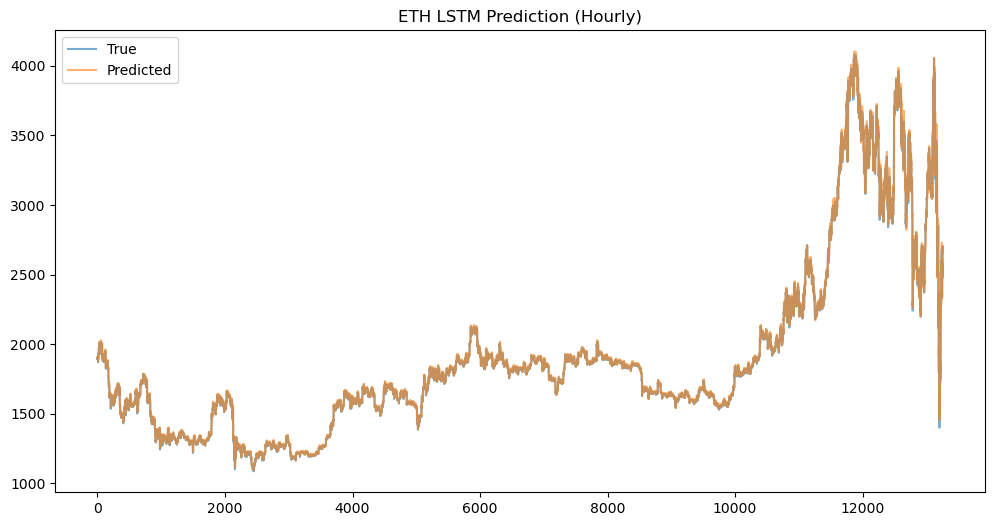

Min Error: -467.018798828125
Max Error: 398.74755859375
Mean Absolute Error in dollars: 13.521358489990234


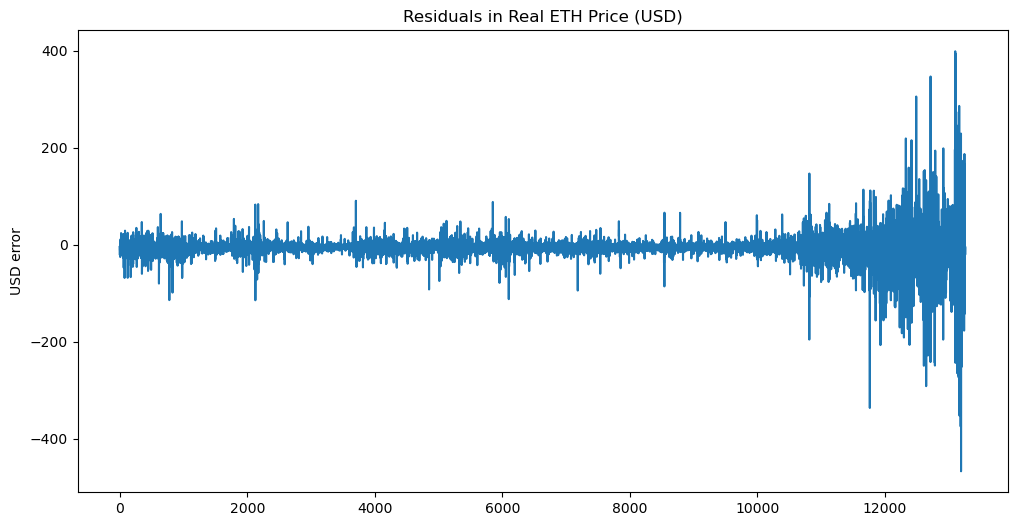


✅ Predicted closes for the next 24 hours:
Hour 1: 2669.14 USD
Hour 2: 2681.58 USD
Hour 3: 2685.59 USD
Hour 4: 2685.70 USD
Hour 5: 2686.45 USD
Hour 6: 2688.44 USD
Hour 7: 2690.38 USD
Hour 8: 2691.63 USD
Hour 9: 2692.37 USD
Hour 10: 2692.86 USD
Hour 11: 2693.22 USD
Hour 12: 2693.44 USD
Hour 13: 2693.56 USD
Hour 14: 2693.61 USD
Hour 15: 2693.63 USD
Hour 16: 2693.64 USD
Hour 17: 2693.64 USD
Hour 18: 2693.64 USD
Hour 19: 2693.63 USD
Hour 20: 2693.63 USD
Hour 21: 2693.62 USD
Hour 22: 2693.62 USD
Hour 23: 2693.62 USD
Hour 24: 2693.62 USD
✅ Predictions saved to 'eth_predicted_next24hours.csv'


In [19]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 1️⃣ Load and preprocess data
df = pd.read_csv('CEX_ETHUSD_1h.csv', skiprows=1)
df.columns = ['unix', 'date', 'symbol', 'open', 'high', 'low', 'close', 'Volume ETH', 'Volume USD']
df = df.drop(columns=['unix', 'symbol', 'Volume USD'])
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date']).reset_index(drop=True)
df = df.sort_values('date').reset_index(drop=True)

# 2️⃣ Feature engineering
df['ma_7'] = df['close'].rolling(window=7).mean()
df['ma_21'] = df['close'].rolling(window=21).mean()
df['ema_7'] = df['close'].ewm(span=7, adjust=False).mean()
df['ema_21'] = df['close'].ewm(span=21, adjust=False).mean()
ema_12 = df['close'].ewm(span=12, adjust=False).mean()
ema_26 = df['close'].ewm(span=26, adjust=False).mean()
df['macd'] = ema_12 - ema_26
df['bollinger_mid'] = df['close'].rolling(window=20).mean()
df['bollinger_std'] = df['close'].rolling(window=20).std()
df['bollinger_upper'] = df['bollinger_mid'] + (df['bollinger_std'] * 2)
df['bollinger_lower'] = df['bollinger_mid'] - (df['bollinger_std'] * 2)
delta = df['close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / (loss + 1e-10)
df['rsi'] = 100 - (100 / (1 + rs))
df = df.fillna(0)

# 3️⃣ Normalize
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.drop(columns=['date']))

# 4️⃣ Create sequences
def create_sequences(data, seq_length=30):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i:i+seq_length])
        ys.append(data[i+seq_length, 3])  # close price index
    return np.array(xs), np.array(ys)

seq_length = 30
X, y = create_sequences(scaled_data, seq_length)

# 5️⃣ Train/test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 6️⃣ Convert to tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float().unsqueeze(1)
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float().unsqueeze(1)

# 7️⃣ DataLoader
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)

# 8️⃣ LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

input_size = X_train.shape[2]
model = LSTMModel(input_size=input_size, hidden_size=50, num_layers=2, output_size=1)

# 🔟 Training loop
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20

for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:
        model.train()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch}, Loss: {loss.item()}")

# 🔵 Save model
torch.save(model.state_dict(), 'best_model.pth')
print("✅ Model weights saved to 'best_model.pth'")

# 🔵 Evaluate
model.eval()
with torch.no_grad():
    y_pred = model(X_test).squeeze().numpy()
    y_true = y_test.squeeze().numpy()

# Denormalize
close_range = scaler.data_max_[3] - scaler.data_min_[3]
close_min = scaler.data_min_[3]
y_pred_rescaled = y_pred * close_range + close_min
y_true_rescaled = y_true * close_range + close_min

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_true_rescaled, label='True', alpha=0.6)
plt.plot(y_pred_rescaled, label='Predicted', alpha=0.6)
plt.legend()
plt.title('ETH LSTM Prediction (Hourly)')
plt.show()

# Residuals
residuals_dollars = y_true_rescaled - y_pred_rescaled
print(f"Min Error: {residuals_dollars.min()}")
print(f"Max Error: {residuals_dollars.max()}")
print(f"Mean Absolute Error in dollars: {np.mean(np.abs(residuals_dollars))}")

plt.figure(figsize=(12, 6))
plt.plot(residuals_dollars)
plt.title("Residuals in Real ETH Price (USD)")
plt.ylabel("USD error")
plt.show()

# 🟩 Predict next 24 hours
predicted_closes = []
current_sequence = scaled_data[-seq_length:].copy()
for _ in range(24):
    input_tensor = torch.tensor(current_sequence[np.newaxis, :, :], dtype=torch.float32)
    with torch.no_grad():
        next_close_scaled = model(input_tensor).item()
    predicted_closes.append(next_close_scaled)
    new_row = current_sequence[-1].copy()
    new_row[3] = next_close_scaled
    current_sequence = np.vstack([current_sequence[1:], new_row])

# Denormalize
predicted_closes_real = [c * close_range + close_min for c in predicted_closes]

# Print predictions
print("\n✅ Predicted closes for the next 24 hours:")
for i, p in enumerate(predicted_closes_real, 1):
    print(f"Hour {i}: {p:.2f} USD")

# Save
df_pred = pd.DataFrame({
    'hour_ahead': range(1, 25),
    'predicted_close': predicted_closes_real
})
df_pred.to_csv('eth_predicted_next24hours.csv', index=False)
print("✅ Predictions saved to 'eth_predicted_next24hours.csv'")

- Implemented an LSTM-based model to predict ETH hourly close prices using historical data.
- Engineered key technical indicators (MA, EMA, MACD, Bollinger Bands, RSI) as additional features.
- Normalized data and constructed sequences of length 30 for training.
- Trained the model for 20 epochs and saved final model weights to 'best_model.pth'.
- Evaluated model predictions on test data, plotted residuals, and quantified prediction error.
- Added script to generate 24-hour ahead ETH price predictions, saved as CSV.
- Manually compared model forecasts to actual price data to validate near-term prediction performance.
- Found model to track real price moves well for the first ~3-6 hours but flattened beyond that.

**Next Steps:**
- Focus on limiting prediction horizon to 3-6 hours for better real-world trading decisions.
- Explore integrating external signals (order books, volume profiles, sentiment data) for long-range predictions.
- Consider ensembling LSTM with other models to improve forecast accuracy and volatility tracking.
- Possibly retrain with new data (3-6 hour chunks only) and experiment with hyperparameter tuning.